In [1]:
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn import metrics
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import spectral_clustering

%matplotlib inline

# STEP 1 : Edge Detection

In [44]:
image = cv2.imread('../File/oil_test_03.jpg')
orig = image.copy()

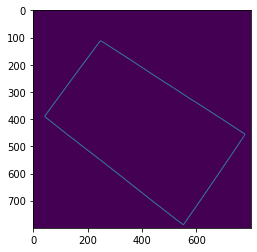

In [45]:
r = 800.0 / image.shape[0]
dim = (int(image.shape[1] * r), 800)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
edged = cv2.Canny(blur, 70, 150)

plt.imshow(edged)

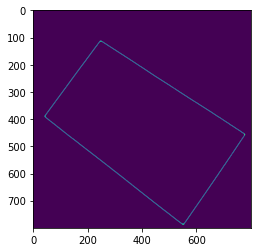

In [46]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
plt.imshow( closed)

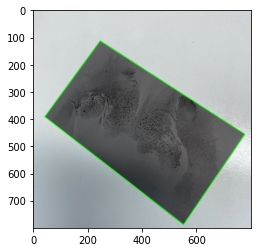

In [47]:
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted(cnts, key = cv2.contourArea, reverse=True)[:3]

for c in cnts:
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        screenCnt = approx
        break
        
cv2.drawContours(image,[screenCnt], -1, (0,255,0), 2)

plt.imshow(image)

In [48]:
print(screenCnt)

[[[246 113]]

 [[ 43 391]]

 [[552 787]]

 [[777 455]]]


In [49]:
def order_points(pts):
    rect = np.zeros((4,2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [50]:
rect = order_points(screenCnt.reshape(4,2) / r)

(topLeft, topRight, bottomRight, bottomLeft) = rect

w1 = abs(bottomRight[0] - bottomLeft[0])
w2 = abs(topRight[0] - topLeft[0])
h1 = abs(topRight[1] - bottomRight[1])
h2 = abs(topLeft[1] - bottomLeft[1])

In [51]:
maxWidth = max([w1, w2])
maxHeight = max([h1, h2])

In [52]:
dst = np.float32([[0,0], [maxWidth-1,0], [maxWidth-1, maxHeight-1], [0,maxHeight-1]])

In [53]:
M = cv2.getPerspectiveTransform(rect, dst)

In [54]:
warped = cv2.warpPerspective(orig,M,(maxWidth,maxHeight))

<ipython-input-54-c02f6d8c19e2>:1: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  warped = cv2.warpPerspective(orig,M,(maxWidth,maxHeight))


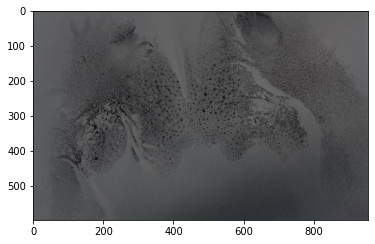

In [55]:
plt.imshow(warped)

In [56]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

In [57]:
warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

In [183]:
type(warped)

numpy.ndarray

In [41]:
warped_thr = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)

In [42]:
df = pd.DataFrame(warped_thr)

In [43]:
df

,0,1,2,3,4,5,6,7,8,9,...,945,946,947,948,949,950,951,952,953,954
0,255,255,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
1,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,255,255,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
593,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
594,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
595,0,255,255,255,255,0,0,0,0,255,...,255,255,255,255,255,255,255,255,255,255


In [19]:
arr = np.empty((1,2), int)

for i in range(len(df.columns)):
    for j in range(len(df.index)):
        item = np.array([[i,j]])
        arr = np.append(arr,item, axis=0)
arr

array([[9218868437227405312, 9218868437227405312],
       [                  0,                   0],
       [                  0,                   1],
       ...,
       [                954,                 594],
       [                954,                 595],
       [                954,                 596]])

In [21]:
arr_y = np.empty((1,), int)

for i in range(len(df.columns)):
    for j in range(len(df.index)):
        item = np.array([df[i][j]])
        arr_y = np.append(arr_y,item, axis=0)
arr_y

array([  0, 255, 255, ..., 255, 255, 255])

In [33]:
# np.save('../File/dbscan_X_arr.npy', arr)
# np.save('../File/dbscan_y_arr.npy', arr_y)

In [83]:
# X = np.load('../File/dbscan_X_arr.npy')
# y = np.load('../File/dbscan_y_arr.npy')

In [22]:
for i in range(len(arr_y)):
    if arr_y[i] == 255:
        arr_y[i] = 1

arr_y

array([0, 1, 1, ..., 1, 1, 1])

In [176]:
arr

array([[9218868437227405312, 9218868437227405312],
       [                  0,                 231],
       [                  0,                 262],
       ...,
       [                954,                 576],
       [                954,                 578],
       [                954,                 589]])

In [177]:
arr_y

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
np.where(0 == arr_y)

(array([     0,    232,    263, ..., 570115, 570117, 570128]),)

In [26]:
indexes = []

for i in range(len(arr_y)):
    if arr_y[i] == 1:
        indexes.append(i)
        
indexes

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [27]:
arr = np.delete(arr, indexes, axis = 0)
        
arr

array([[9218868437227405312, 9218868437227405312],
       [                  0,                 231],
       [                  0,                 262],
       ...,
       [                954,                 576],
       [                954,                 578],
       [                954,                 589]])

In [28]:
arr.shape

(51570, 2)

In [29]:
arr_y = np.delete(arr_y, indexes, axis = 0)
        
arr_y

array([0, 0, 0, ..., 0, 0, 0])

In [178]:
arr_y.shape

(51570,)

In [31]:
X = arr
y = arr_y

In [32]:
X = np.delete(X, 0, axis = 0)
        
X

array([[  0, 231],
       [  0, 262],
       [  0, 267],
       ...,
       [954, 576],
       [954, 578],
       [954, 589]])

In [58]:
warped

array([[190, 153, 101, ..., 166, 162, 164],
       [182, 134,  87, ..., 101, 101,  92],
       [179, 118,  75, ..., 111, 107, 101],
       ...,
       [ 81,  92,  95, ...,  75,  72,  60],
       [ 78,  90,  86, ...,  75,  70,  58],
       [104, 106, 108, ...,  75,  69,  58]], dtype=uint8)

In [63]:
df_warped = pd.DataFrame(warped)

In [64]:
df_warped

,0,1,2,3,4,5,6,7,8,9,...,945,946,947,948,949,950,951,952,953,954
0,190,153,101,98,104,99,102,103,104,100,...,155,161,168,157,157,158,162,166,162,164
1,182,134,87,92,101,101,100,98,96,96,...,102,95,97,98,102,102,101,101,101,92
2,179,118,75,92,98,100,100,99,97,95,...,108,106,105,100,102,105,111,111,107,101
3,194,125,82,93,99,102,101,101,100,99,...,103,106,104,101,102,103,106,107,107,102
4,194,152,92,99,99,99,98,101,101,99,...,105,108,106,106,105,104,102,103,105,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,84,95,92,95,96,100,99,100,101,94,...,67,66,67,71,74,73,69,71,72,65
593,80,92,93,96,97,96,96,96,96,96,...,70,67,65,73,73,72,71,74,74,60
594,81,92,95,95,91,93,91,85,92,99,...,71,70,63,64,66,73,74,75,72,60
595,78,90,86,89,85,79,77,73,78,94,...,71,73,68,67,66,72,75,75,70,58


In [62]:
X

array([[  0, 231],
       [  0, 262],
       [  0, 267],
       ...,
       [954, 576],
       [954, 578],
       [954, 589]])

In [172]:
for i in range(len(df.columns)):
    for j in range(len(df.index)):
        if df[i][j] == 255:
            df_warped[i][j] = None
#         else:
#             df_warped[i][j] = df_warped[i][j]

<ipython-input-172-fb68fe1f75f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_warped[i][j] = None
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [173]:
df_warped

,0,1,2,3,4,5,6,7,8,9,...,945,946,947,948,949,950,951,952,953,954
0,NaN,NaN,101.0,98.0,104.0,99.0,102.0,103.0,104.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,134.0,87.0,92.0,101.0,101.0,100.0,98.0,96.0,96.0,...,102.0,95.0,97.0,98.0,102.0,102.0,101.0,101.0,101.0,92.0
2,NaN,118.0,75.0,92.0,98.0,100.0,100.0,99.0,97.0,95.0,...,108.0,106.0,105.0,100.0,102.0,105.0,111.0,111.0,107.0,101.0
3,NaN,125.0,82.0,93.0,99.0,102.0,101.0,101.0,100.0,99.0,...,103.0,106.0,104.0,101.0,102.0,103.0,106.0,107.0,107.0,102.0
4,NaN,NaN,92.0,99.0,99.0,99.0,98.0,101.0,101.0,99.0,...,105.0,108.0,106.0,106.0,105.0,104.0,102.0,103.0,105.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
595,78.0,NaN,NaN,NaN,NaN,79.0,77.0,73.0,78.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


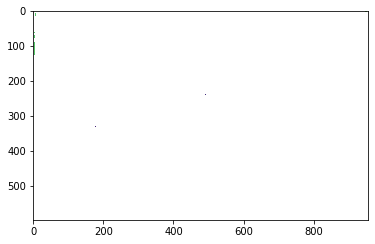

In [179]:
plt.imshow(df_warped)

In [180]:
test_trans = df_warped.to_numpy()

In [181]:
test_trans

array([[ nan,  nan, 101., ...,  nan,  nan,  nan],
       [ nan, 134.,  87., ..., 101., 101.,  92.],
       [ nan, 118.,  75., ..., 111., 107., 101.],
       ...,
       [ 81.,  nan,  nan, ...,  nan,  nan,  nan],
       [ 78.,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [187]:
from PIL import Image

image = Image.fromarray(test_trans.astype('uint8'), 'L')

In [236]:
type(image)

PIL.Image.Image

In [237]:
# image.save('../File/test_01.jpg')

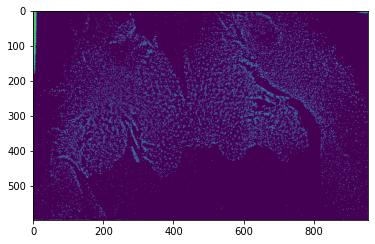

In [201]:
plt.imshow(image)

In [207]:
test_trans.shape

(597, 955)

In [213]:
597*955

570135

In [217]:
test_trans

array([[ nan,  nan, 101., ...,  nan,  nan,  nan],
       [ nan, 134.,  87., ..., 101., 101.,  92.],
       [ nan, 118.,  75., ..., 111., 107., 101.],
       ...,
       [ 81.,  nan,  nan, ...,  nan,  nan,  nan],
       [ 78.,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [228]:
df_warped.notnull().sum().sum()

51569

In [238]:
(df_warped <= 70).sum().sum()

45811

In [239]:
(df_warped <= 70).sum().sum()/df_warped.notnull().sum().sum()

0.8883437724214159

In [243]:
test_trans_df = pd.DataFrame(test_trans)

In [244]:
test_trans_df

,0,1,2,3,4,5,6,7,8,9,...,945,946,947,948,949,950,951,952,953,954
0,NaN,NaN,101.0,98.0,104.0,99.0,102.0,103.0,104.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,134.0,87.0,92.0,101.0,101.0,100.0,98.0,96.0,96.0,...,102.0,95.0,97.0,98.0,102.0,102.0,101.0,101.0,101.0,92.0
2,NaN,118.0,75.0,92.0,98.0,100.0,100.0,99.0,97.0,95.0,...,108.0,106.0,105.0,100.0,102.0,105.0,111.0,111.0,107.0,101.0
3,NaN,125.0,82.0,93.0,99.0,102.0,101.0,101.0,100.0,99.0,...,103.0,106.0,104.0,101.0,102.0,103.0,106.0,107.0,107.0,102.0
4,NaN,NaN,92.0,99.0,99.0,99.0,98.0,101.0,101.0,99.0,...,105.0,108.0,106.0,106.0,105.0,104.0,102.0,103.0,105.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
595,78.0,NaN,NaN,NaN,NaN,79.0,77.0,73.0,78.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
test_trans_not_null_count = test_trans_df.notnull().sum().sum()
test_trans_not_null_count

51569

In [254]:
test_trans_sum = test_trans_df.sum().sum()
test_trans_sum

2820901.0

In [252]:
test_trans_mean = test_trans_df.sum().sum() / test_trans_df.notnull().sum().sum()
test_trans_mean

54.701487327658086

### 평균보다 작은 값(유분이 진하게 묻어나오는 값)의 비율

In [255]:
(test_trans_df <= test_trans_mean).sum().sum()/test_trans_not_null_count

0.444627586340631